In [6]:
import torch
from d2l import torch as d2l

In [36]:
class SoftMax:
    def __init__(self, num_inputs, num_outputs):
        self.num_inputs, self.num_outputs = num_inputs, num_outputs
        self.params = self._init_params()
        
    def _init_params(self):
        """初始化参数"""
        num_inputs = self.num_inputs; num_outputs = self.num_outputs
        def normal(shape):
            return torch.randn(size=shape, device=device) * 0.01
        W = normal((num_inputs, num_outputs)); b = torch.zeros(num_outputs, device=device)
        params = [W, b]
        for param in params:
            param.requires_grad_(True)
        return params
    
    def softmax(self, X):
        X_exp = torch.exp(X)
        partition = X_exp.sum(1, keepdim=True)
        return X_exp / partition  # 这里应用了广播机制
    
    def _forward(self, inputs):
        """推理函数"""
        outputs = []
        W, b = self.params
        for X in inputs:
            Y = self.softmax(X.reshape((-1, W.shape[0])) @ W + b)
            outputs.append(Y)
        return torch.cat(outputs, dim=0)
    
    def update(self, X, y, lr):
        """更新函数"""
        y_hat = self._forward(X)
        l = self._loss(y_hat, y)
        l.mean().backward()
        """sgd"""
        with torch.no_grad():
            for param in self.params:
                param -= lr * param.grad / X.shape[0]
                param.grad.zero_()
        return l
                
    def _loss(self, y_hat, y):
        """交叉熵损失"""
        return - torch.log(y_hat[range(len(y_hat)), y])
                
    def __call__(self, X):
        return self._forward(X)

In [26]:
from tqdm import tqdm

In [33]:
batch_size, device = 256, 'cpu'
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=28)
num_epochs, num_inputs, num_outputs = 3, 784, 10
net = SoftMax(num_inputs, num_outputs)

In [34]:
for epoch in range(num_epochs):
    metrics = [0, 0]
    for X, y in tqdm(train_iter, ncols=100):
        l = net.update(X, y, lr=1)
        metrics[0] += l.sum(); metrics[1] += y.numel()
    print('epoch %d loss %f' % (epoch + 1, metrics[0] / metrics[1]))

100%|█████████████████████████████████████████████████████████████| 235/235 [00:21<00:00, 10.69it/s]


epoch 1 loss 1.717922


100%|█████████████████████████████████████████████████████████████| 235/235 [00:22<00:00, 10.57it/s]


epoch 2 loss 1.207941


100%|█████████████████████████████████████████████████████████████| 235/235 [00:22<00:00, 10.50it/s]

epoch 3 loss 1.028340


array([<AxesSubplot:title={'center':'ankle boot\nankle boot'}>,
       <AxesSubplot:title={'center':'pullover\npullover'}>,
       <AxesSubplot:title={'center':'trouser\ntrouser'}>,
       <AxesSubplot:title={'center':'trouser\ntrouser'}>,
       <AxesSubplot:title={'center':'shirt\nshirt'}>,
       <AxesSubplot:title={'center':'trouser\ntrouser'}>], dtype=object)

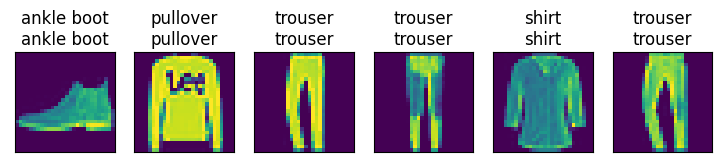

In [35]:
for X, y in test_iter:
    break
n = 6
trues = d2l.get_fashion_mnist_labels(y)
preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
d2l.show_images(
    X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])